Import librerie

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from lime import lime_text
import unicodedata
import pandas as pd
from string import punctuation
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn import preprocessing
import time
import random
import torch.nn.functional as F

Import dataset

In [4]:
df = pd.read_excel('../input/ciao9cci/politica.xlsx', sheet_name="Foglio1")
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

le = preprocessing.LabelEncoder()
le.fit(df['cap_maj_master'])
df['cap_maj_master']=le.transform(df['cap_maj_master'])
classes = [int(c) for c in df['cap_maj_master'].values]
documents = [d for d in df['testo']]

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


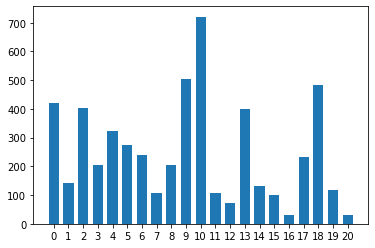

In [5]:
y = np.bincount(classes)
x = np.arange(len(y))
fig, ax = plt.subplots()
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [6]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words('italian'))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words('italian'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

In [7]:
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    for tokens in tokenized:
        for t in tokens:
            all_text.append(t)
    return tokenized, set(all_text)

documents, vocab = split_words_documents(documents)

In [8]:
print(np.max([len(x) for x in documents]))
print(np.mean([len(x) for x in documents]))
quant=np.quantile([len(x) for x in documents],.75)
print(quant)

1375
200.98799542682926
248.0


In [9]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [10]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli_more)

In [11]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    length=[]
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
            length.append(seq_length)
        else:
            length.append(len(document))
            documents.append(['']*(seq_length-len(document))+document)
    return np.array(documents),np.array(length)


In [12]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

In [13]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [14]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, "../input/fasttext-aligned-word-vectors/wiki.it.align.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:40, 21507.74it/s]


There are 144467 / 294543 pretrained vectors found.


In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE='cpu'
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [16]:
def sort_batch(X,lengths,y):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X,lengths, y 

In [17]:
def create_data_loader(train_c,train_len, valid_c, valid_len, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    x_train_len = torch.tensor(train_len, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    x_cv_len = torch.tensor(valid_len, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train,x_train_len, y_train)
    valid = torch.utils.data.TensorDataset(x_cv,x_cv_len, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

In [18]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
import numpy as np
import torch
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [20]:
class ClassificationRNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                freeze_embedding=False,
                 n_vocab=None,
                 hidden_dim=100,
                 output_dim=13,
                 dropout = 0.8,
                 pad_idx=0.0,
                 num_layers=2,
                bidirectional=True):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(self.n_embed, 
                           hidden_dim,
                           num_layers=num_layers,
                          bidirectional=bidirectional,
                          dropout=0 if num_layers < 2 else dropout)
        self.fc1 = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        

        
        
    def forward(self, text, text_length):
        h_embedding = self.dropout(self.embedding(text))
        h_lstm, _ = self.rnn(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc=self.fc1(conc)
        conc = self.relu(conc)
        conc = self.dropout(conc)
        out = self.fc2(conc)
        return out

In [21]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch,len_batch, y_batch) in enumerate(data_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            logits= model(x_batch,len_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [22]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch,len_batch, y_batch) in enumerate(train_loader):
            #x_batch,len_batch, y_batch=sort_batch(x_batch,len_batch, y_batch)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch,len_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

In [23]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text,length, label) in test_loader: 
            #text,length, label=sort_batch(text,length, label)
            outputs = model(text,length)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [24]:
batch_size = 128
output_dim = len(np.unique(classes))
print(output_dim)
dropout_pc = 0.1
n_epochs = 100
nfold=10
patience=5
hidden_dim=64
lr = 1e-3
num_layers=1
bidirectional=True

21


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.859869  | 294.724126 |   11.41   |   2.63   
Validation loss decreased (inf --> 294.724126).  Saving model ...
   2    |  357.499154  | 292.096358 |   11.41   |   2.46   
Validation loss decreased (294.724126 --> 292.096358).  Saving model ...
   3    |  351.328969  | 283.891526 |   11.41   |   2.50   
Validation loss decreased (292.096358 --> 283.891526).  Saving model ...
   4    |  321.204652  | 250.656223 |   30.62   |   2.48   
Validation loss decreased (283.891526 --> 250.656223).  Saving model ...
   5    |  264.813223  | 214.447781 |   34.35   |   2.48   
Validation loss decreased (250.656223 --> 214.447781).  Saving model ...
   6    |  210.223521  | 188.955565 |   39.51   |   2.66   
Validation loss decreased (214.447781 --> 188.955565).  Saving model ...
   7    |  161

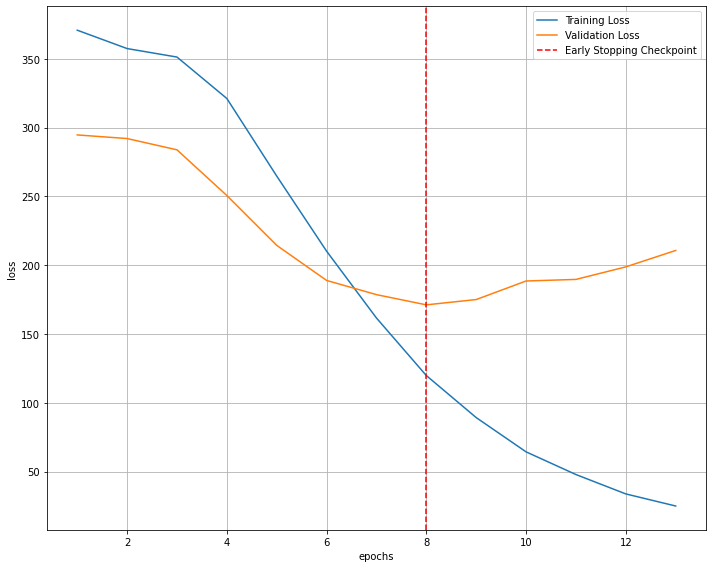

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.47      0.60      0.53        42
           1       0.20      0.07      0.10        15
           2       0.83      0.75      0.79        40
           3       0.70      0.67      0.68        21
           4       0.61      0.53      0.57        32
           5       0.77      0.89      0.83        27
           6       0.71      0.50      0.59        24
           7       0.67      0.36      0.47        11
           8       0.60      0.45      0.51        20
           9       0.73      0.80      0.76        50
          10       0.65      0.73      0.68        73
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.31      0.28      0.29        40
          14       0.27      0.23      0.25        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

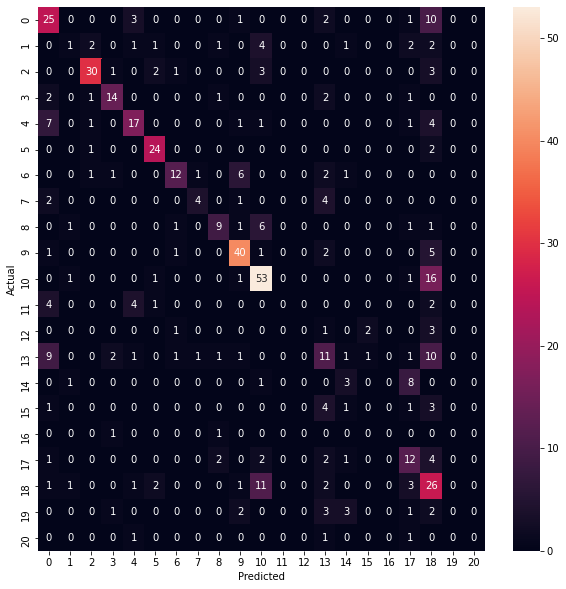


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.580360  | 294.705728 |   11.25   |   2.46   
Validation loss decreased (inf --> 294.705728).  Saving model ...
   2    |  358.132071  | 291.925912 |   11.25   |   2.48   
Validation loss decreased (294.705728 --> 291.925912).  Saving model ...
   3    |  348.471251  | 278.330118 |   20.31   |   2.59   
Validation loss decreased (291.925912 --> 278.330118).  Saving model ...
   4    |  306.898383  | 232.976208 |   34.06   |   2.49   
Validation loss decreased (278.330118 --> 232.976208).  Saving model ...
   5    |  241.361064  | 194.888992 |   47.22   |   2.48   
Validation loss decreased (232.976208 --> 194.888992).  Saving model ...
   6    |  184.033432  | 177.305365 |   48.03   |   2.47   
Validation loss decreased (194.888992 --> 177.305365).  Saving model ...
   7    |  14

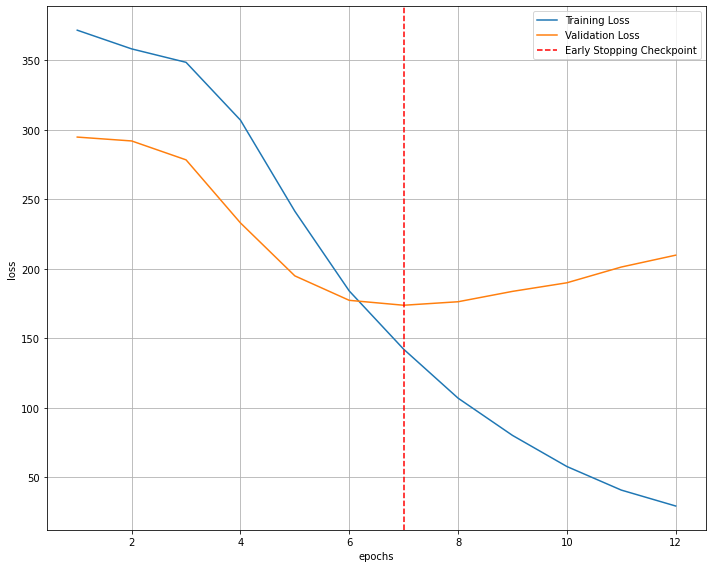

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.36      0.64      0.47        42
           1       0.33      0.07      0.11        15
           2       0.69      0.82      0.75        40
           3       0.43      0.43      0.43        21
           4       0.73      0.50      0.59        32
           5       0.86      0.89      0.87        27
           6       0.57      0.67      0.62        24
           7       0.50      0.09      0.15        11
           8       0.50      0.25      0.33        20
           9       0.75      0.86      0.80        50
          10       0.64      0.76      0.70        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.28      0.30      0.29        40
          14       0.42      0.38      0.40        13
          15       0.50      0.10      0.17        10
          16       0.00      0.00

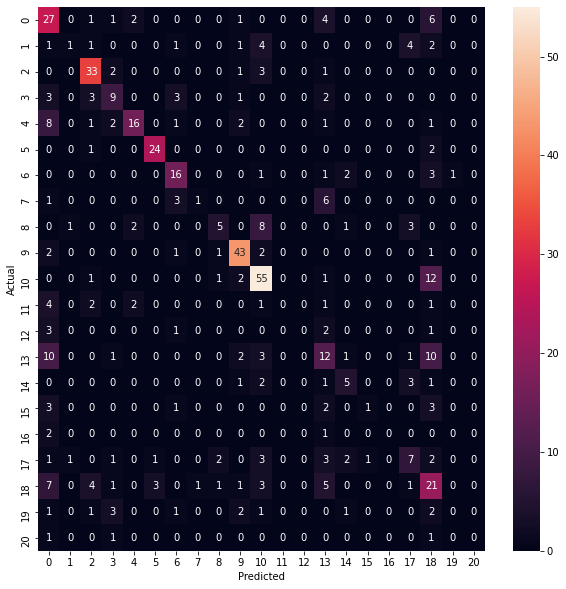


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  368.752048  | 295.044676 |   11.25   |   2.51   
Validation loss decreased (inf --> 295.044676).  Saving model ...
   2    |  357.492428  | 292.087305 |   11.25   |   2.49   
Validation loss decreased (295.044676 --> 292.087305).  Saving model ...
   3    |  352.768998  | 284.741919 |   12.34   |   2.48   
Validation loss decreased (292.087305 --> 284.741919).  Saving model ...
   4    |  325.190716  | 247.083624 |   28.12   |   2.49   
Validation loss decreased (284.741919 --> 247.083624).  Saving model ...
   5    |  263.933690  | 204.020875 |   39.15   |   2.49   
Validation loss decreased (247.083624 --> 204.020875).  Saving model ...
   6    |  203.039055  | 173.816428 |   49.41   |   2.48   
Validation loss decreased (204.020875 --> 173.816428).  Saving model ...
   7    |  15

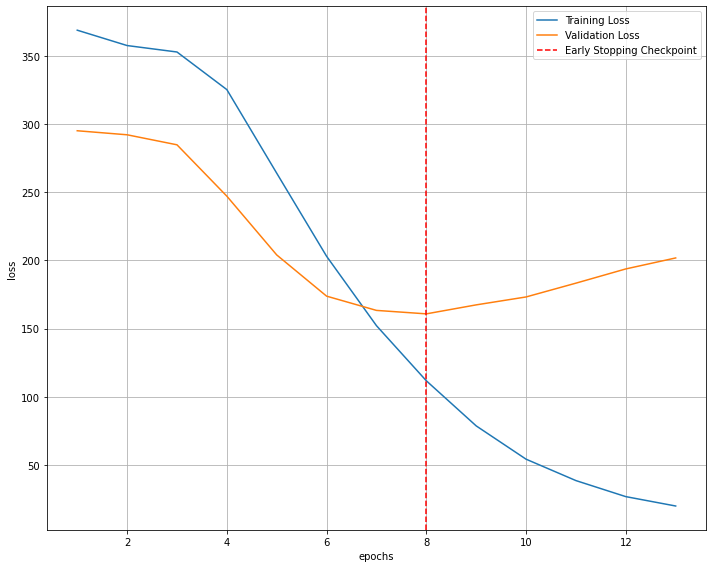

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.29      0.43      0.34        42
           1       0.40      0.13      0.20        15
           2       0.77      0.82      0.80        40
           3       0.75      0.60      0.67        20
           4       0.52      0.42      0.47        33
           5       0.72      0.75      0.74        28
           6       0.64      0.67      0.65        24
           7       0.50      0.36      0.42        11
           8       0.55      0.55      0.55        20
           9       0.76      0.76      0.76        50
          10       0.56      0.69      0.62        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.30      0.40      0.34        40
          14       0.33      0.15      0.21        13
          15       0.50      0.10      0.17        10
          16       0.00      0.00

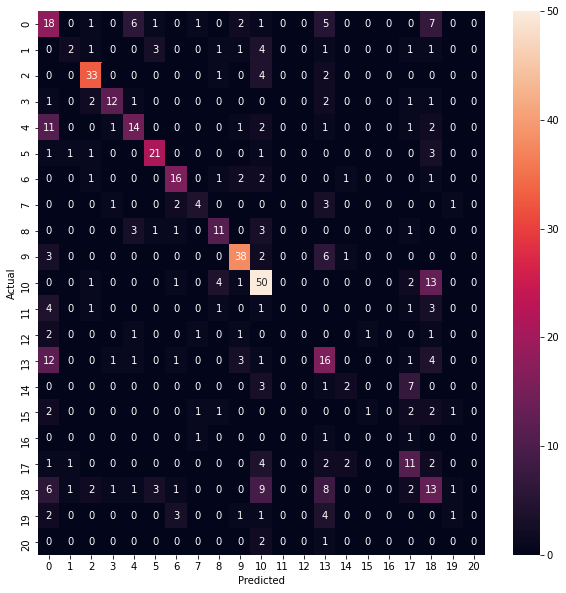


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  369.674063  | 295.233602 |   8.28    |   2.46   
Validation loss decreased (inf --> 295.233602).  Saving model ...
   2    |  357.361201  | 290.408448 |   11.25   |   2.47   
Validation loss decreased (295.233602 --> 290.408448).  Saving model ...
   3    |  346.940215  | 275.131656 |   17.19   |   2.47   
Validation loss decreased (290.408448 --> 275.131656).  Saving model ...
   4    |  307.667043  | 236.770471 |   30.47   |   2.50   
Validation loss decreased (275.131656 --> 236.770471).  Saving model ...
   5    |  249.794016  | 198.003584 |   44.46   |   2.50   
Validation loss decreased (236.770471 --> 198.003584).  Saving model ...
   6    |  189.544629  | 170.104626 |   52.67   |   2.56   
Validation loss decreased (198.003584 --> 170.104626).  Saving model ...
   7    |  13

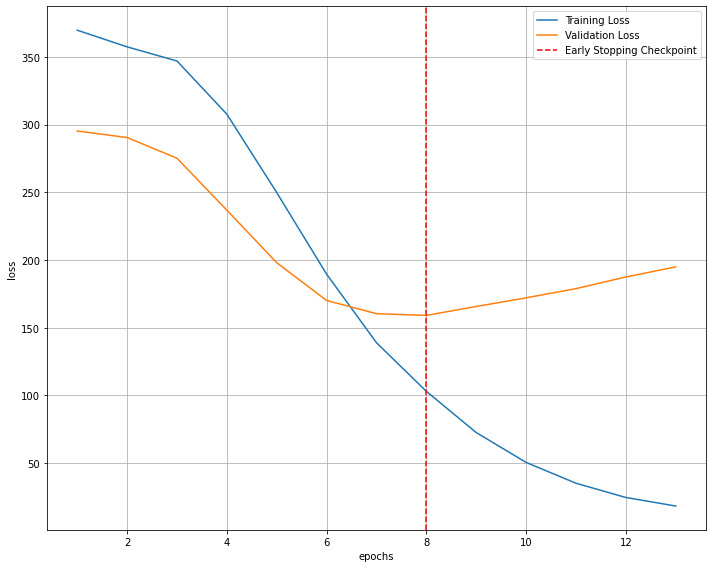

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.47      0.38      0.42        42
           1       0.50      0.07      0.12        14
           2       0.74      0.80      0.77        40
           3       0.82      0.70      0.76        20
           4       0.45      0.61      0.52        33
           5       0.79      0.79      0.79        28
           6       0.61      0.79      0.69        24
           7       0.33      0.18      0.24        11
           8       0.56      0.50      0.53        20
           9       0.70      0.80      0.75        50
          10       0.63      0.83      0.72        72
          11       0.00      0.00      0.00        11
          12       1.00      0.14      0.25         7
          13       0.40      0.42      0.41        40
          14       0.62      0.38      0.48        13
          15       0.50      0.10      0.17        10
          16       0.00      0.00

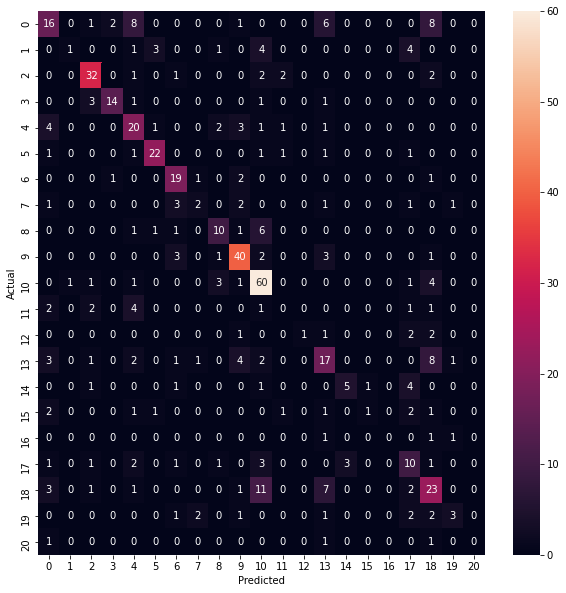


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  369.090583  | 293.944128 |   11.25   |   2.48   
Validation loss decreased (inf --> 293.944128).  Saving model ...
   2    |  356.629737  | 290.729748 |   11.25   |   2.48   
Validation loss decreased (293.944128 --> 290.729748).  Saving model ...
   3    |  348.812204  | 279.435120 |   15.31   |   2.48   
Validation loss decreased (290.729748 --> 279.435120).  Saving model ...
   4    |  321.872034  | 250.900435 |   29.53   |   2.48   
Validation loss decreased (279.435120 --> 250.900435).  Saving model ...
   5    |  261.411554  | 200.292010 |   38.10   |   2.48   
Validation loss decreased (250.900435 --> 200.292010).  Saving model ...
   6    |  197.485579  | 174.732335 |   51.26   |   2.50   
Validation loss decreased (200.292010 --> 174.732335).  Saving model ...
   7    |  15

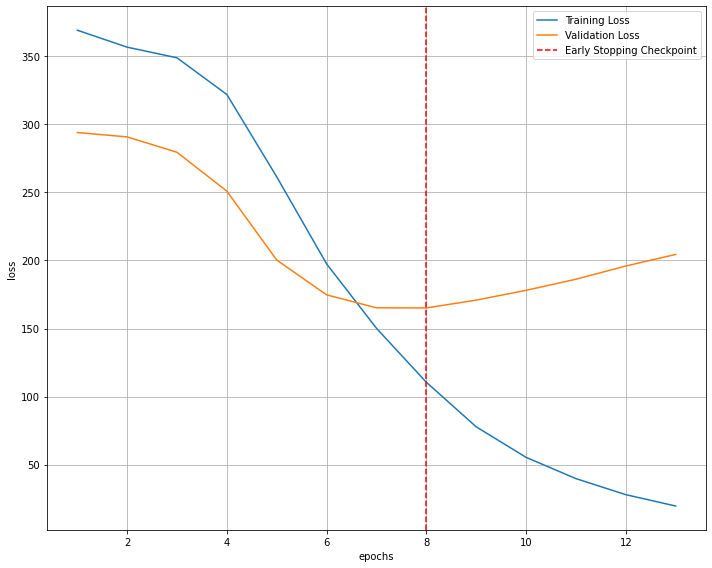

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.27      0.24      0.25        42
           1       0.00      0.00      0.00        14
           2       0.66      0.72      0.69        40
           3       0.59      0.65      0.62        20
           4       0.40      0.52      0.45        33
           5       0.69      0.86      0.76        28
           6       0.61      0.74      0.67        23
           7       0.60      0.55      0.57        11
           8       0.76      0.65      0.70        20
           9       0.72      0.86      0.78        50
          10       0.62      0.83      0.71        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.39      0.38      0.38        40
          14       0.33      0.14      0.20        14
          15       1.00      0.10      0.18        10
          16       0.00      0.00

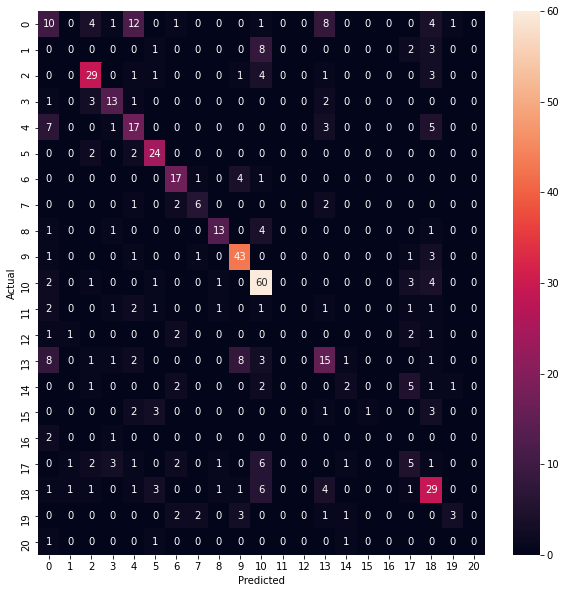


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  376.300868  | 294.056324 |   11.25   |   2.47   
Validation loss decreased (inf --> 294.056324).  Saving model ...
   2    |  358.452059  | 291.759307 |   11.25   |   2.48   
Validation loss decreased (294.056324 --> 291.759307).  Saving model ...
   3    |  351.382216  | 281.134145 |   12.03   |   2.46   
Validation loss decreased (291.759307 --> 281.134145).  Saving model ...
   4    |  327.760935  | 254.474346 |   20.62   |   2.48   
Validation loss decreased (281.134145 --> 254.474346).  Saving model ...
   5    |  282.567271  | 219.913746 |   34.53   |   2.50   
Validation loss decreased (254.474346 --> 219.913746).  Saving model ...
   6    |  231.019878  | 196.560579 |   37.19   |   2.51   
Validation loss decreased (219.913746 --> 196.560579).  Saving model ...
   7    |  18

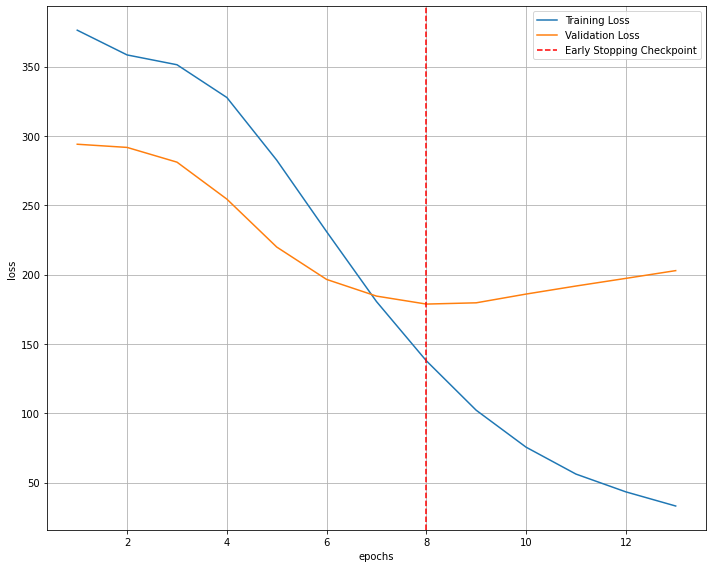

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.31      0.45      0.37        42
           1       0.20      0.07      0.11        14
           2       0.82      0.82      0.82        40
           3       0.59      0.85      0.69        20
           4       0.32      0.36      0.34        33
           5       0.69      0.67      0.68        27
           6       0.54      0.29      0.38        24
           7       0.00      0.00      0.00        11
           8       0.32      0.40      0.36        20
           9       0.73      0.75      0.74        51
          10       0.63      0.83      0.72        72
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         7
          13       0.25      0.33      0.29        40
          14       0.50      0.14      0.22        14
          15       0.00      0.00      0.00        10
          16       0.00      0.00

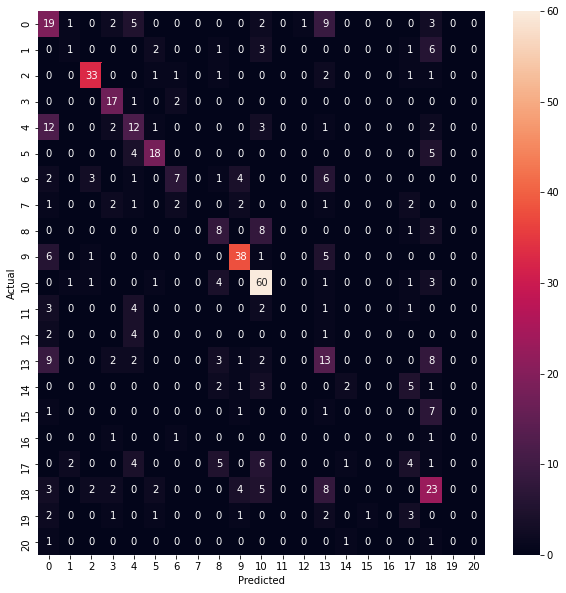


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.636220  | 293.720094 |   11.25   |   2.73   
Validation loss decreased (inf --> 293.720094).  Saving model ...
   2    |  357.580265  | 290.570752 |   11.25   |   2.49   
Validation loss decreased (293.720094 --> 290.570752).  Saving model ...
   3    |  350.550879  | 277.473464 |   14.38   |   2.50   
Validation loss decreased (290.570752 --> 277.473464).  Saving model ...
   4    |  319.796684  | 234.357113 |   31.98   |   2.48   
Validation loss decreased (277.473464 --> 234.357113).  Saving model ...
   5    |  256.038457  | 185.782596 |   53.85   |   2.49   
Validation loss decreased (234.357113 --> 185.782596).  Saving model ...
   6    |  193.612245  | 160.697675 |   55.28   |   2.50   
Validation loss decreased (185.782596 --> 160.697675).  Saving model ...
   7    |  14

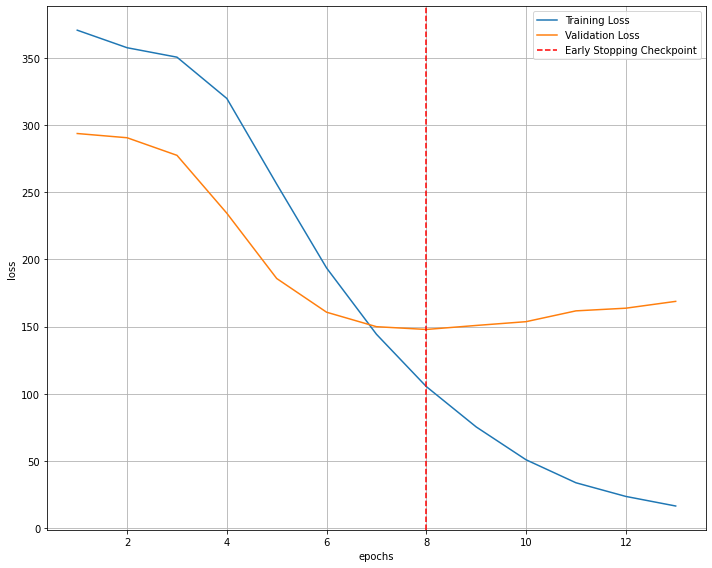

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.42      0.40      0.41        42
           1       1.00      0.07      0.13        14
           2       0.83      0.73      0.78        41
           3       0.62      0.65      0.63        20
           4       0.39      0.56      0.46        32
           5       0.74      0.96      0.84        27
           6       0.47      0.75      0.58        24
           7       0.50      0.18      0.27        11
           8       0.60      0.71      0.65        21
           9       0.89      0.78      0.83        51
          10       0.75      0.89      0.82        72
          11       1.00      0.09      0.17        11
          12       0.00      0.00      0.00         7
          13       0.31      0.41      0.35        39
          14       0.43      0.23      0.30        13
          15       0.71      0.45      0.56        11
          16       0.00      0.00

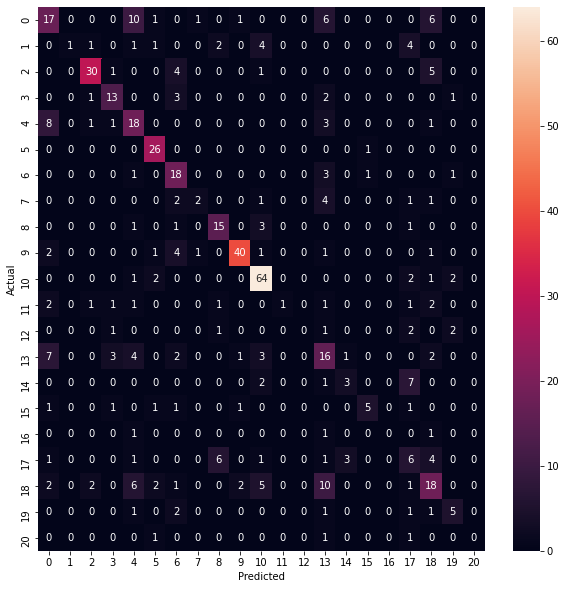


train: (4723, 248) len: 4723
test: (525, 248) len: 525
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  370.647947  | 293.701123 |   11.25   |   2.47   
Validation loss decreased (inf --> 293.701123).  Saving model ...
   2    |  357.907044  | 291.677230 |   11.25   |   2.48   
Validation loss decreased (293.701123 --> 291.677230).  Saving model ...
   3    |  351.047640  | 277.527747 |   16.09   |   2.50   
Validation loss decreased (291.677230 --> 277.527747).  Saving model ...
   4    |  314.429760  | 228.868334 |   36.20   |   2.49   
Validation loss decreased (277.527747 --> 228.868334).  Saving model ...
   5    |  249.706269  | 189.655953 |   42.14   |   2.51   
Validation loss decreased (228.868334 --> 189.655953).  Saving model ...
   6    |  192.784254  | 169.746508 |   50.48   |   2.49   
Validation loss decreased (189.655953 --> 169.746508).  Saving model ...
   7    |  14

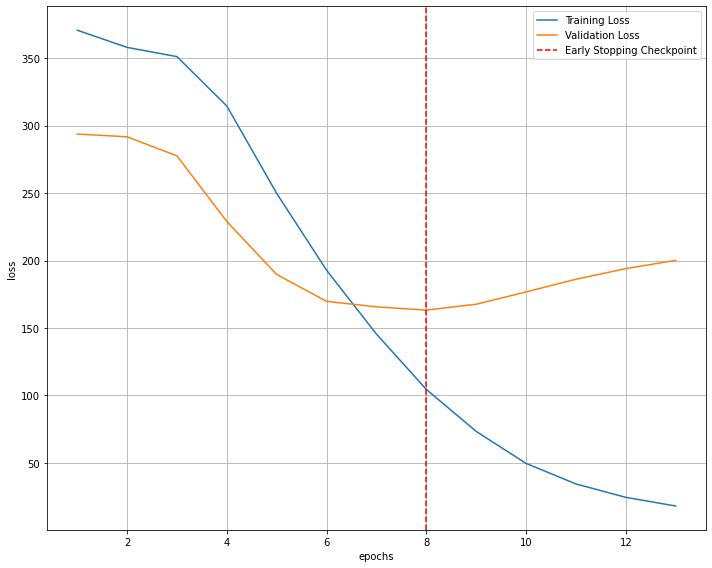

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.43      0.55      0.48        42
           1       0.75      0.21      0.33        14
           2       0.67      0.90      0.77        41
           3       0.79      0.71      0.75        21
           4       0.53      0.78      0.63        32
           5       0.75      0.89      0.81        27
           6       0.43      0.38      0.40        24
           7       0.43      0.30      0.35        10
           8       0.72      0.62      0.67        21
           9       0.68      0.75      0.71        51
          10       0.75      0.74      0.74        72
          11       0.50      0.10      0.17        10
          12       0.00      0.00      0.00         8
          13       0.38      0.45      0.41        40
          14       0.70      0.54      0.61        13
          15       0.33      0.20      0.25        10
          16       0.00      0.00

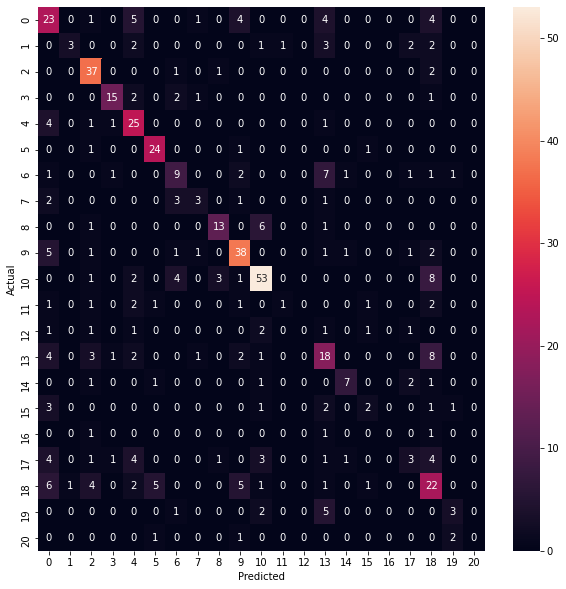


train: (4724, 248) len: 4724
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  368.342567  | 292.889295 |   11.25   |   2.47   
Validation loss decreased (inf --> 292.889295).  Saving model ...
   2    |  356.761487  | 289.463488 |   11.25   |   2.52   
Validation loss decreased (292.889295 --> 289.463488).  Saving model ...
   3    |  347.128295  | 271.217935 |   17.66   |   2.48   
Validation loss decreased (289.463488 --> 271.217935).  Saving model ...
   4    |  303.623656  | 224.976884 |   35.26   |   2.49   
Validation loss decreased (271.217935 --> 224.976884).  Saving model ...
   5    |  238.763251  | 183.619428 |   53.07   |   2.47   
Validation loss decreased (224.976884 --> 183.619428).  Saving model ...
   6    |  180.826093  | 165.814266 |   56.46   |   2.49   
Validation loss decreased (183.619428 --> 165.814266).  Saving model ...
   7    |  13

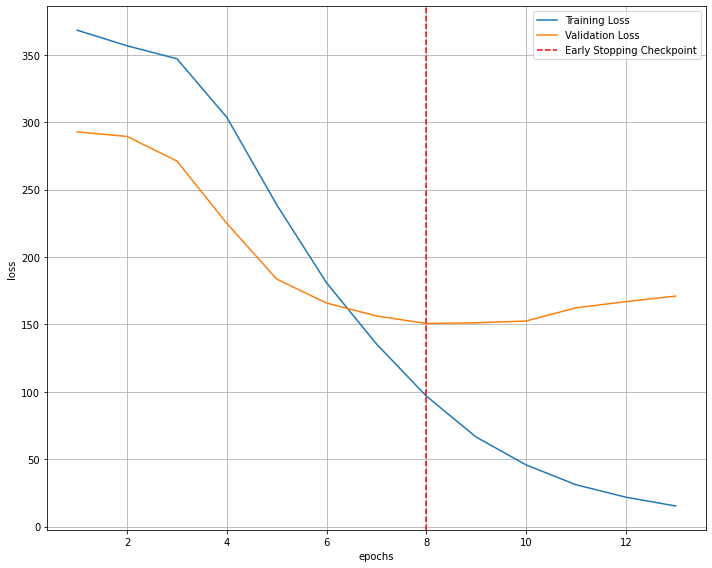

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.40      0.40      0.40        42
           1       0.33      0.29      0.31        14
           2       0.86      0.73      0.79        41
           3       0.80      0.95      0.87        21
           4       0.54      0.66      0.59        32
           5       0.53      0.78      0.63        27
           6       0.57      0.88      0.69        24
           7       0.75      0.30      0.43        10
           8       0.62      0.71      0.67        21
           9       0.76      0.82      0.79        51
          10       0.70      0.76      0.73        72
          11       0.50      0.10      0.17        10
          12       0.00      0.00      0.00         8
          13       0.35      0.38      0.36        40
          14       0.50      0.08      0.13        13
          15       0.50      0.20      0.29        10
          16       0.00      0.00

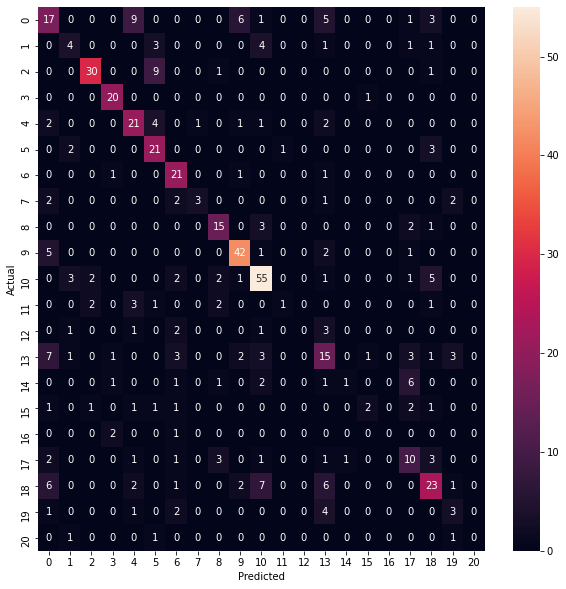


train: (4724, 248) len: 4724
test: (524, 248) len: 524
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  371.758330  | 294.382587 |   11.25   |   2.48   
Validation loss decreased (inf --> 294.382587).  Saving model ...
   2    |  358.350546  | 291.219019 |   11.25   |   2.49   
Validation loss decreased (294.382587 --> 291.219019).  Saving model ...
   3    |  351.445753  | 281.203268 |   11.25   |   2.49   
Validation loss decreased (291.219019 --> 281.203268).  Saving model ...
   4    |  322.181042  | 242.999960 |   34.06   |   2.49   
Validation loss decreased (281.203268 --> 242.999960).  Saving model ...
   5    |  267.248886  | 206.746467 |   41.09   |   2.48   
Validation loss decreased (242.999960 --> 206.746467).  Saving model ...
   6    |  214.604051  | 183.765404 |   48.59   |   2.47   
Validation loss decreased (206.746467 --> 183.765404).  Saving model ...
   7    |  16

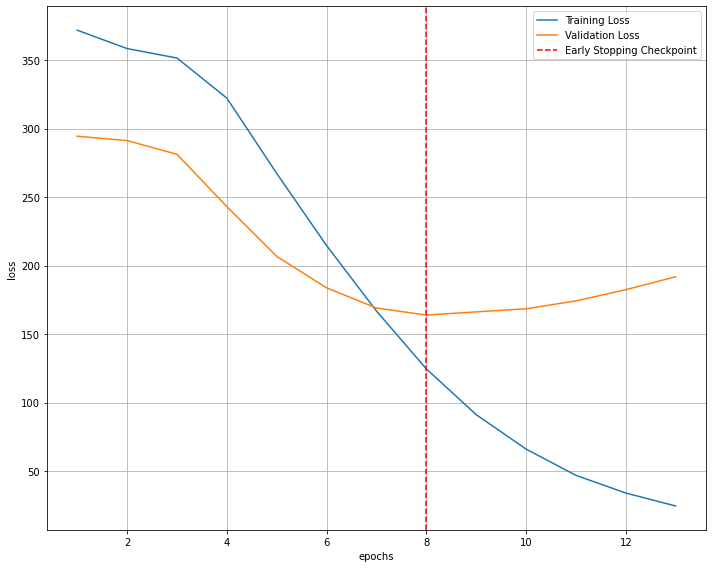

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.46      0.57      0.51        42
           1       0.00      0.00      0.00        14
           2       0.82      0.82      0.82        40
           3       0.54      0.67      0.60        21
           4       0.57      0.66      0.61        32
           5       0.69      0.89      0.77        27
           6       0.62      0.67      0.64        24
           7       0.25      0.10      0.14        10
           8       0.40      0.85      0.55        20
           9       0.81      0.82      0.82        51
          10       0.78      0.54      0.64        72
          11       0.11      0.10      0.11        10
          12       0.00      0.00      0.00         8
          13       0.48      0.50      0.49        40
          14       1.00      0.15      0.27        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

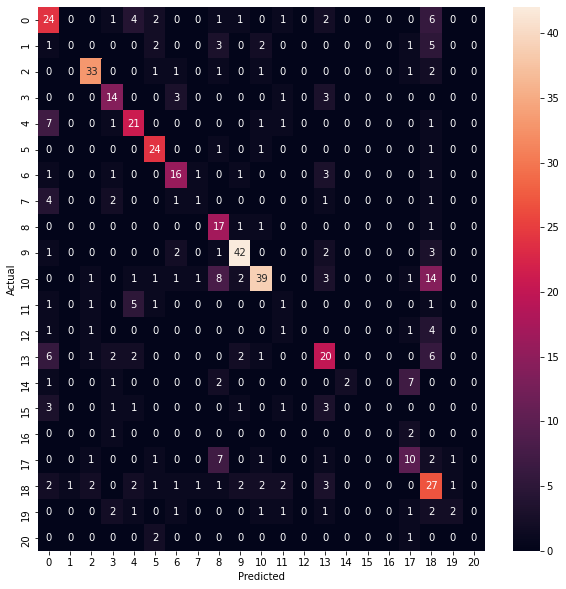

In [25]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

y=np.array(classes)
documents=np.array(documents)
kfold = StratifiedKFold(n_splits=nfold).split(documents, y)

accuracys = []
scores= []
metriche = np.zeros((nfold,4,output_dim))
target_names=np.unique(classes)
#target_names=le.inverse_transform(target_names)

for k, (train_ids, test_ids) in enumerate(kfold):
    padded_sentences_train,lenght_train = pad_text(documents[train_ids], seq_length = int(quant))
    padded_sentences_test,lenght_test = pad_text(documents[test_ids], seq_length = int(quant))
    
    encoded_sentences_train = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_train])
    encoded_sentences_test  = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences_test])
    
    print("train:",encoded_sentences_train.shape,"len:",lenght_train.size)
    print("test:",encoded_sentences_test.shape,"len:",lenght_test.size)
    
    train_loader, val_loader=create_data_loader(encoded_sentences_train,lenght_train,
                                                encoded_sentences_test,lenght_test,
                                                y[train_ids],y[test_ids],batch_size)
    
    
    model = ClassificationRNN(
                        pretrained_embedding=embeddings, 
                        output_dim=output_dim,
                        dropout=dropout_pc,
                        hidden_dim=hidden_dim,
                        num_layers=num_layers,
                        bidirectional=bidirectional
                        )
    model=model.double()
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    accuracys.append(metrics.accuracy_score(y_true, y_pred))
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<output_dim:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


In [28]:
print("Overall results of the cross-validation procedure")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(output_dim):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f} +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")
print()
print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

Overall results of the cross-validation procedure

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 38.82 +/- 7.27  | 46.67 +/-11.58  | 41.82 +/- 7.87  |   42.00  
   1    | 37.17 +/-29.89  | 9.81  +/- 8.56  | 14.16 +/-10.59  |   14.30  
   2    | 77.05 +/- 7.13  | 79.41 +/- 5.49  | 77.86 +/- 3.68  |   40.30  
   3    | 66.26 +/-12.37  | 68.79 +/-13.26  | 66.97 +/-11.05  |   20.50  
   4    | 50.48 +/-11.36  | 55.97 +/-11.53  | 52.25 +/- 8.82  |   32.40  
   5    | 72.23 +/- 8.28  | 83.56 +/- 8.35  | 77.17 +/- 7.11  |   27.30  
   6    | 57.61 +/- 7.65  | 63.22 +/-17.69  | 58.99 +/-10.67  |   23.90  
   7    | 45.29 +/-20.58  | 24.27 +/-15.40  | 30.43 +/-16.67  |   10.70  
   8    | 56.42 +/-12.68  | 56.98 +/-16.73  | 55.16 +/-12.15  |   20.30  
   9    | 75.30 +/- 5.68  | 80.02 +/- 4.02  | 77.45 +/- 3.60  |   50.50  
  10    | 67.05 +/- 6.71  | 76.15 +/- 9.30  | 70.73 +/- 5.19  |   72.10  
  11    | 21.11 +/-32.66  | 3.91  +/- 4.79  | 6.05  +/- 7.60 